This notebook prototypes code that reads buoy data from NDBC and generates a pulsing signal with amplitude proportional to wave height and 

In [100]:
%matplotlib inline
import matplotlib as mpl
import pylab as PP
import datetime as dt
import pandas as pd
import numpy as np
import time

In [129]:
class WaveSignal:
    
    def __init__(self, \
                 buoy_id, \
                 ndbc_realtime_data_template = "https://www.ndbc.noaa.gov/data/realtime2/{}.txt", \
                 max_wave_height = 4.0):
        
        self.buoy_id = buoy_id
        self.ndbc_realtime_url = ndbc_realtime_data_template.format(buoy_id)
        self.max_wave_height = max_wave_height
        
        self.data_table = None
        self.most_recent_obs = None
        self.wave_height = None
        self.wave_direction = None
        self.wave_period = None
        self.has_good_data = False
        self.update_buoy_data()
        self.time0 = dt.datetime.now()
        
    def update_buoy_data(self):
        """ Updates the buoy data table """
        
        try:
            data_table = pd.read_fwf(self.ndbc_realtime_url,header=[0,1])
        except:
            # TODO: raise a warning if data access fails
            # if accessing the URL  didn't work, simply keep using the same data table
            data_table = self.data_table
        
        self.data_table = data_table
        
        if self.data_table is not None:
            # loop over rows to search for valid data
            for n in range(len(self.data_table)):
                try:
                    year = int(self.data_table['#YY'].loc[n])
                    month = int(self.data_table['MM'].loc[n])
                    day = int(self.data_table['DD'].loc[n])
                    hour = int(self.data_table['hh'].loc[n])
                    minute = int(self.data_table['mm'].loc[n])
                    # set the most recent observation date
                    self.most_recent_obs = dt.datetime(year,month,day,hour,minute)
                except:
                    self.most_recent_obs = None

                try:
                    self.wave_height, self.wave_period, self.wave_direction = \
                        float(self.data_table[('WVHT', 'm')].loc[n]), \
                        float(self.data_table[('DPD', 'sec')].loc[n]), \
                        float(self.data_table[('MWD   PRES', 'degT   hPa')].loc[n].split()[0])
                except:
                    self.wave_height, self.wave_period, self.wave_direction = None, None, None
                    self.has_good_data = False

                # set the list of variables needed for a complete observation
                critical_data_list = [\
                                      self.most_recent_obs, \
                                      self.wave_height, \
                                      self.wave_period, \
                                      self.wave_direction, \
                                     ]
                # if valid data have been found, break out of the loop
                if all([ item is not None for item in critical_data_list]):
                    self.has_good_data = True
                    break
                    
                    
    def get_color(self, \
                  saturation = 0.66666, \
                  value = 1.0):
        """ Returns an RGB color corresponding to wave direction """
        if self.has_good_data:
            # set the color
            hue = self.wave_direction/360
            rgb = mpl.colors.hsv_to_rgb((hue, saturation, value))
        else:
            rgb = (0,0,0)
        
        return rgb

    def get_signal(self, \
                   num_wave_repetitions = 1, \
                   samples_per_second = 30):
        """ Returns a repeating sinusoidal signal with amplitude proportional to wave height and 
            period proportional to wave period. If no data are available, an array of missing values 
            is returned."""
        
        if self.has_good_data:
            # set the number of samples
            nsamples = int(num_wave_repetitions*self.wave_period*samples_per_second)
            # set the time vector
            time = np.linspace(0,num_wave_repetitions*self.wave_period, nsamples+1)[:-1]
            
            amplitude = self.wave_height / self.max_wave_height
            
            # create the signal
            signal = amplitude*np.sin(2*np.pi*time/self.wave_period)
        else: 
            time = np.arange(128)
            signal = np.ma.masked_all(128)
            
        return time, signal
        
    def get_seconds_elapsed(self):
        """ Gets the seconds elapsed, for the purposes of signal generation """
        # get and store the current time
        self.current_time = dt.datetime.now()
        return (self.time0 - self.current_time).total_seconds()
        
        
        
    def get_wave_sample(self, \
                        saturation = 0.6666666):
        """ Returns an RGB value that represents time along a sinusoidal wave """
        
        
        # if we have good data
        if self.has_good_data:
            # set and clip the amplitude to 1
            amplitude = min(self.wave_height / self.max_wave_height, 1.0)
            
            # create the signal (ranges from 0 to 1 maximum)
            signal = amplitude*np.sin(2*np.pi*self.get_seconds_elapsed()/self.wave_period)
            if np.isclose(signal,0.0):
                # reset the time counter to avoid eventual overflow issues
                self.time0 = self.current_time
                
            # get the color; it's brightness will be proportional to the current sine-wave amplitude
            # that represents the wave pulse
            rgb = self.get_color(value=signal, saturation = saturation)
        else:
            rgb = (0,0,0)
            
        return rgb, signal
        
        

In [130]:
test1 = WaveSignal(46054)

In [139]:
t0 = dt.datetime.now()
current_time = t0
times = []
values = []
colors = []
while (current_time-t0).total_seconds() < 2*test1.wave_period:
    color, value = test1.get_wave_sample()
    times.append((test1.current_time - t0).total_seconds())
    colors.append(color)
    values.append(value)
    # sleep for a 30th of a second
    time.sleep(1/30)
    current_time = dt.datetime.now()
   

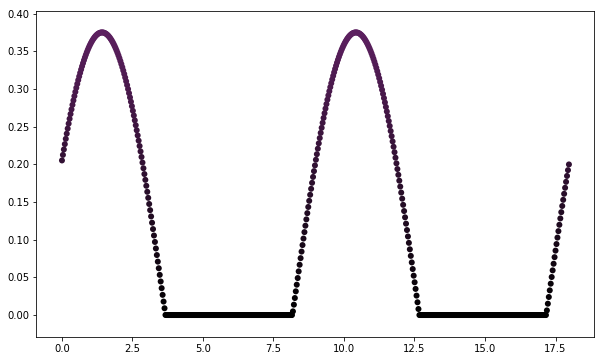

In [144]:
 
fig,ax  = PP.subplots(figsize=(10,6))

ax.scatter(times, np.array(values).clip(min=0,max=1), c=np.array(colors).clip(min=0,max=1),lw=0,edgecolor=(0,0,0,1))

PP.show()

        

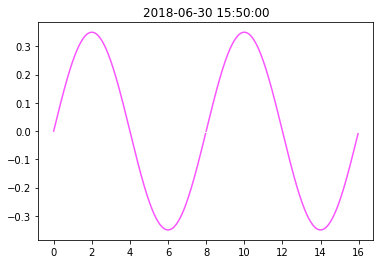

In [88]:
def plot_wave_signal(wave_signal):
    color = wave_signal.get_color()
    time, signal = wave_signal.get_signal()
    
    fig, ax = PP.subplots()
    
    ax.plot(time, signal, color=color)
    ax.plot(time+wave_signal.wave_period, signal, color=color)
    ax.set_title(str(wave_signal.most_recent_obs))
    
    PP.show()
    
plot_wave_signal(test1)